# How to inject artifical signals into K2 light curves

`lightkurve` will include classes to inject artificial signals (e.g. supernovae, planetary transits, rotation, flares) into K2, Kepler, TESS, and potentially ground based light curves. 

Let's download a K2 light curve of a galaxy. Currently, injection works on the light curve level, so we'll need to construct a light curve from the target pixel file.

In [1]:
%load_ext autoreload 
%autoreload 2

from lightkurve import KeplerTargetPixelFile
import lightkurve.injection as inj
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()              

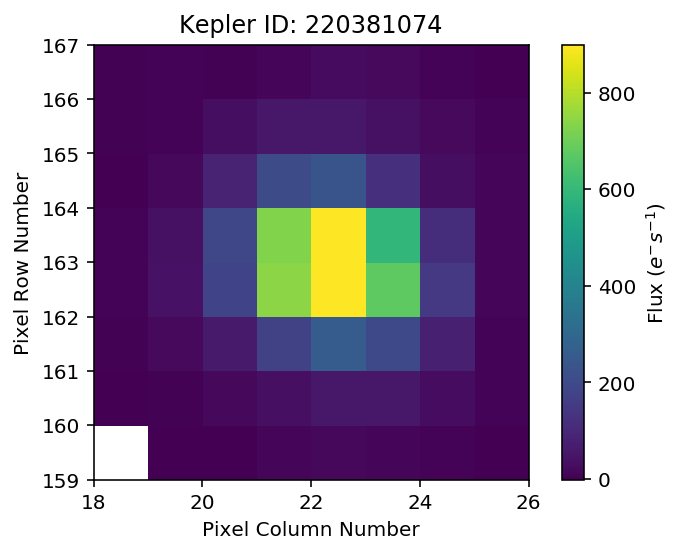

In [2]:
tpf.plot();

(0, 1.5)

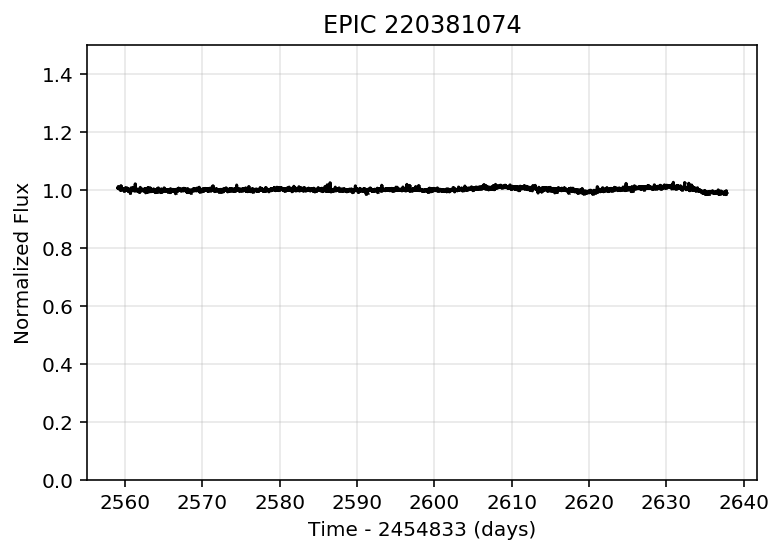

In [3]:
lc.plot();
plt.title('EPIC 220381074')
plt.ylim(0, 1.5)

This light curve of this galaxy is fairly smooth, but there may be some variability from the spacecraft motion and thermal fluctuations.
Now let's create a supernova model with the new `SupernovaModel` class. You'll need to install [sncosmo](http://sncosmo.readthedocs.io/) for this class to work.

We can specify the source, bandpass, and redshift of the supernova model. These attributes are common to every source.

In [4]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=3.e-4)

Now we can construct the light curve by using the `.evaluate` method.  We can specify the time array for the supernova model, $t_0$, and parameters specific to the source - in this case, amplitude.

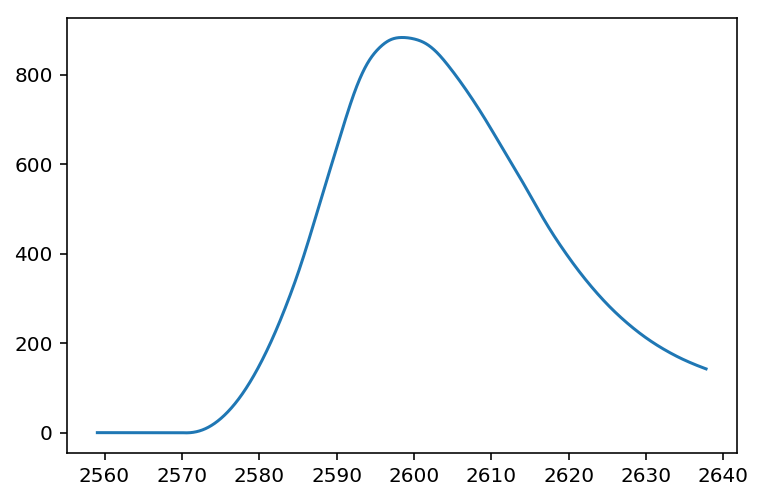

In [5]:
flux = model.evaluate(lc.time)
plt.plot(lc.time, flux)

Finally, we can inject the supernova model into our K2 light curve using the `.inejct` method. (We don't actually need to realize the model to do this.) Let's plot the K2 light curve and the injected light curve next to it.

[1.65486344e-17 1.65486344e-17 1.65486344e-17 ... 1.42834690e+02
 1.42705801e+02 1.42577141e+02]


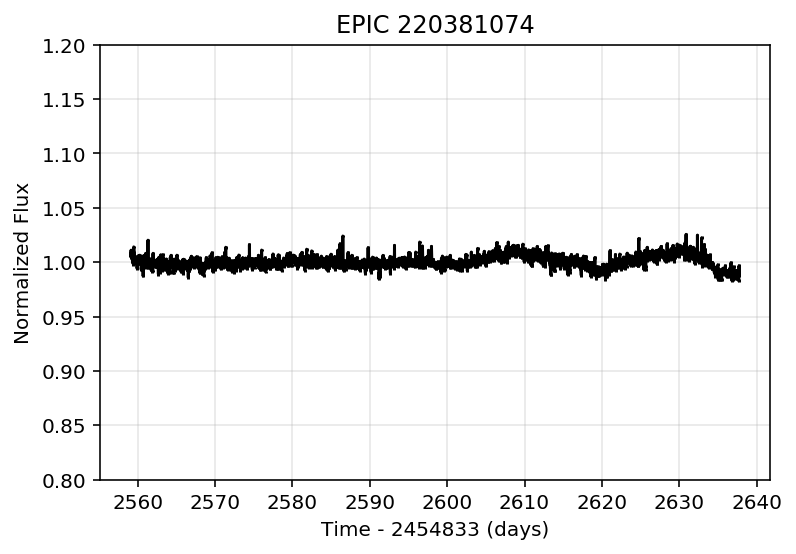

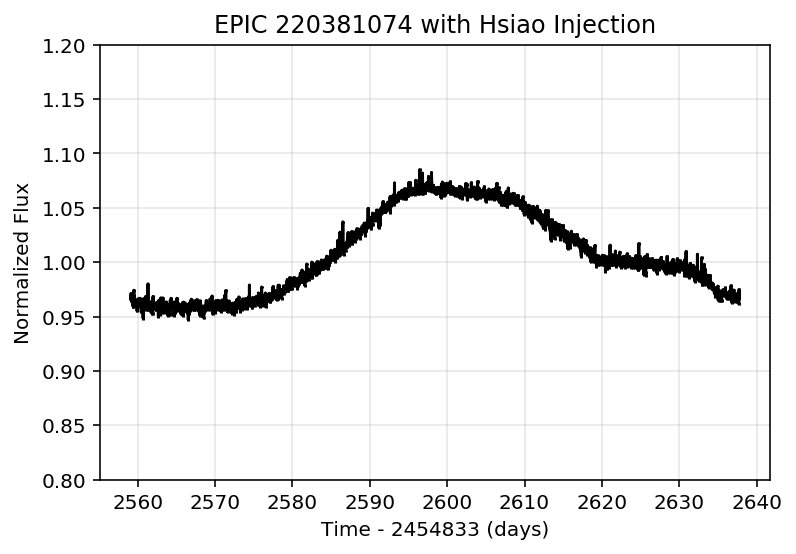

In [6]:
lcinj = inj.inject(lc, model)

#K2 light curve
lc.plot()
plt.title('EPIC 220381074')
plt.ylim(0.8,1.2)

#K2 light curve with injection
lcinj.plot()
plt.title('EPIC 220381074 with Hsiao Injection')
plt.ylim(0.8,1.2)

print(lcinj.signal)

We injected a supernova light curve into this galaxy!

This supernova is based on the [Hsiao](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H) source 
and takes three parameters: redshift $z$, amplitude, and $t_0$ (time of zero phase). 
<br>
(Note: depending on the source, $t_0$ may specify the beginning or the peak of the supernova.)
<br>

You can specify the source and input the parameters belonging to this source accordingly. Paramters can also be chosen randomly from a uniform distribution using `inj.UniformDistribution`, or a Gaussian distribution using `inj.GaussianDistribution`. For example, let's simulate a supernova with the SALT2 model, which takes 5 parameters ($t_0$, $z$, $x_0$, $x_1$, and $c$), and choose $z$ randomly from a Gaussian distribution with mean 0.5 and sigma 0.2:

Text(0.5,1,'EPIC 220381074 with SALT2 Injection')

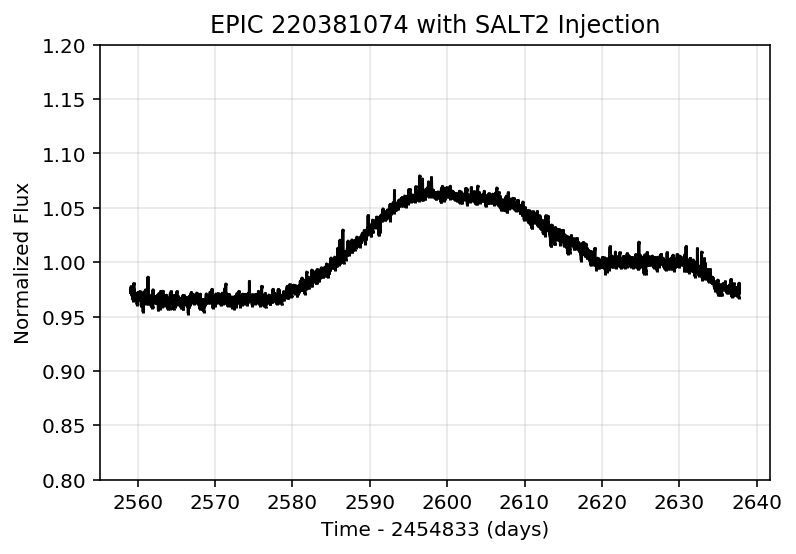

In [8]:
model = inj.SupernovaModel(T0=2600, source='salt2', bandpass='kepler', z=inj.UniformDistribution(0.3,0.5), x0=5, x1=1.e-2, c=-.1)
lcinj = inj.inject(lc, model)
lcinj.plot()
plt.ylim(0.8,1.2)
plt.title('EPIC 220381074 with SALT2 Injection')

Every time you create a new model, a new $z$ will be chosen from this Gaussian distribution, so you can quickly inject supernovae of many $z$ values.

We can also use the .inject method to inject a planetary transit. Let's download the Kepler light curve of a G-type star:

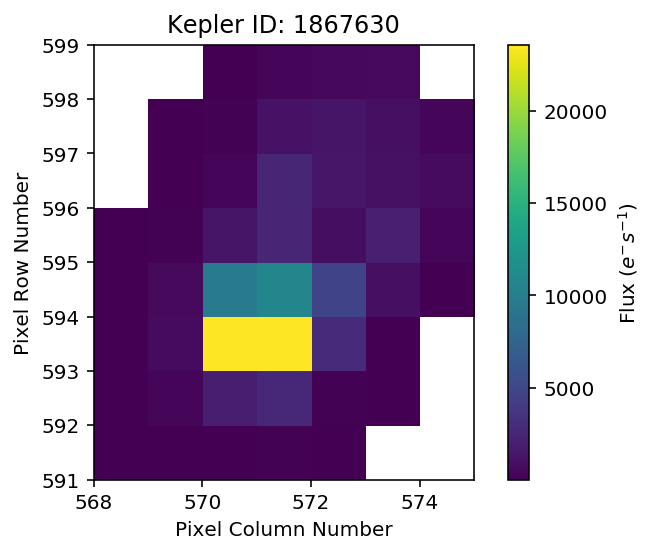

In [9]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

tpf.plot()

(0, 1.2)

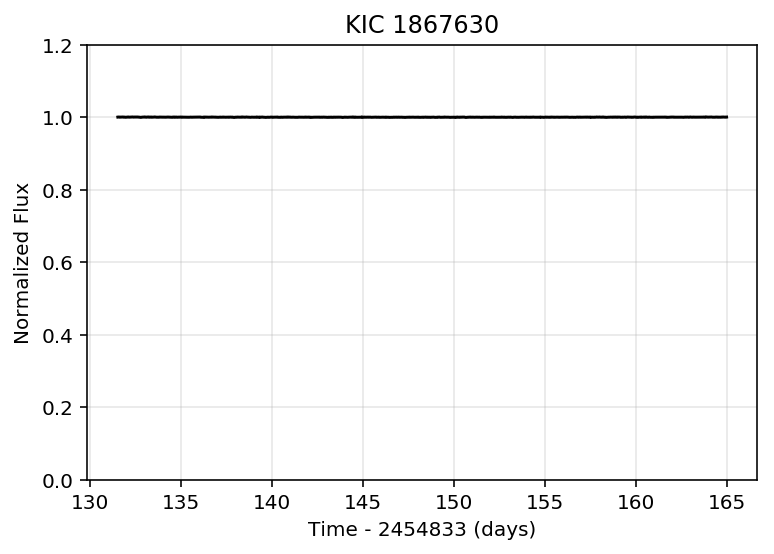

In [10]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(0, 1.2)

The Kepler light curve of this star is very smooth, but if we zoom in we can see that there is some slight variability: 

(0.985, 1.004)

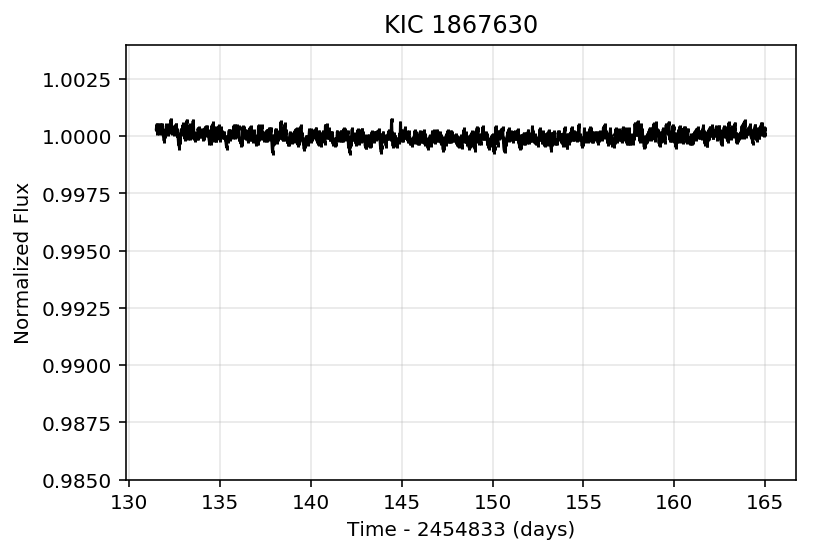

In [11]:
lc.plot();
plt.title('KIC 1867630')
plt.ylim(0.985, 1.004)
#plt.savefig('/Users/sheilasagear/Desktop/lc_notransits')

Now let's inject a planetary transit into this light curve. We're going to inject a jupiter-sized planet with an orbital period chosen from a uniform distribution between 4 and 8 days using `TransitModel`.

(0.985, 1.004)

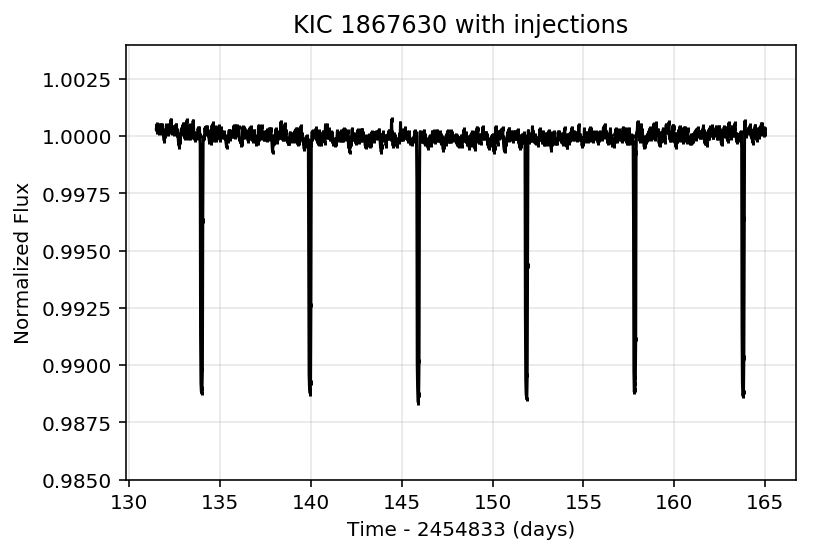

In [13]:
model = inj.TransitModel()
model.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model.add_planet(period=inj.UniformDistribution(4,8), T0=134, rprs=.1)


lc_transit = inj.inject(lc, model)
#print(lc_transit.period)

#print(lc_transit.signal)

lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
#plt.savefig('/Users/sheilasagear/Desktop/lc_1transit')

You can add as many planets as you want:

## Exploratory analysis:

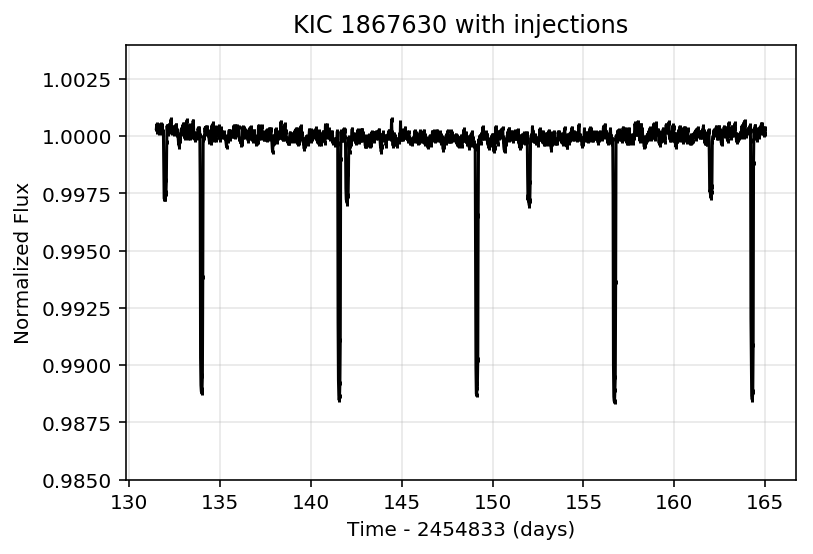

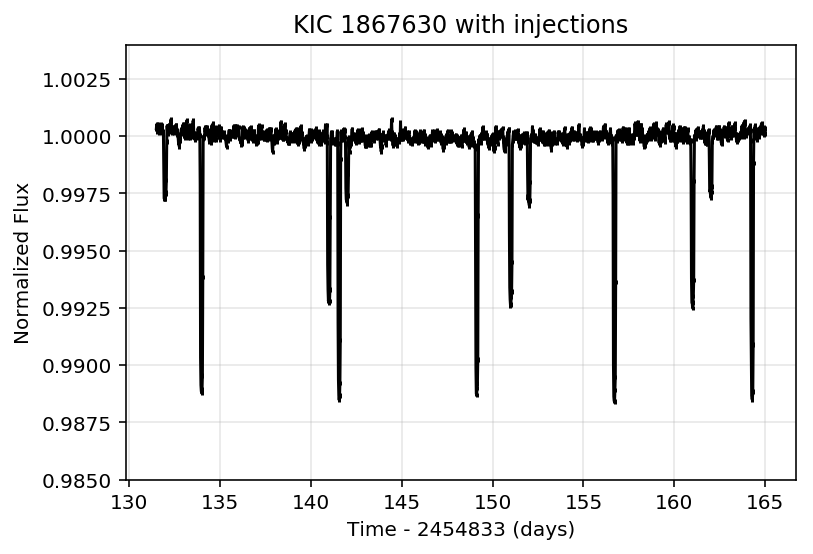

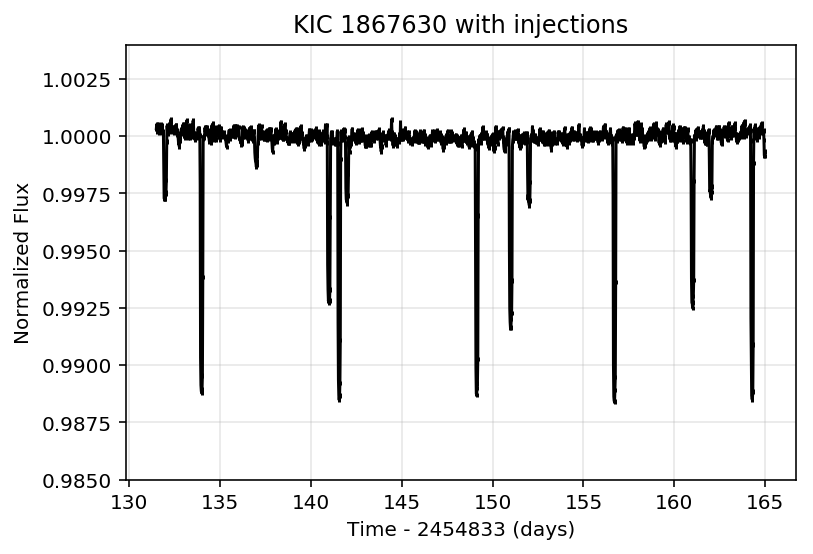

In [12]:
model.add_planet(period=10, rprs=.05, T0=132, impact=0.01)
lc_transit = inj.inject(lc, model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
plt.savefig('/Users/sheilasagear/Desktop/lc_2transit')

model.add_planet(period=10, rprs=.08, T0=131, impact=0.0)
lc_transit = inj.inject(lc, model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
plt.savefig('/Users/sheilasagear/Desktop/lc_3transit')

model.add_planet(period=14, rprs=.03, T0=137, impact=0.4)
lc_transit = inj.inject(lc, model)
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)
plt.savefig('/Users/sheilasagear/Desktop/lc_4transit')

You can specify the orbital period and radius ratio, but also the impact parameter, eccentricity, stellar density, and limb darkening law, etc.

lc.model

lc.signal -- an array

read sff paper and watch gully's tutorial abt sff

for w, b
    lc.inject.correct(w,b)

In [87]:
lc_transit.chisq(model, 3, period=[1, 2, 3], rprs=[0.1,0.2,0.3], impact=[0.0, 0.1, 0.2])

{'impact': [0.0, 0.1, 0.2], 'period': [1, 2, 3], 'rprs': [0.1, 0.2, 0.3]}
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.  1.  0.1 0. ]
 [0.1 2.  0.2 0. ]
 [0.2 3.  0.3 0. ]]


In [70]:
#add signal attribute to TransitModel and SupernovaModel
p  = (1,2,3,4,5)
r  = (1,2,3,4,5)
x  = (1,2,3,4,5)

N_parsa = 3

def count():
    number = len(data)
    
    new_dat = np.zeros(shape=(len(data),N_parsa))
    
    return (new_dat)
    

In [25]:
count(data)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])